# Определение перспективного тарифа для телеком компании

### Импорт библиотек и загрузка данных

Импорт необходимых библиотек.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

Загрузка датасетов.

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Первый взгляд на данные

Первый вгляд на данные. Напишем вспомогательную функцию first_look.
Посмотрим на датасеты в следующем порядке:
1. calls
2. internet
3. messages
4. tariffs
5. users

In [3]:
def first_look(df, sample_size=5):
    display(df.sample(sample_size))
    return df.info()

Датасет **calls**:

In [4]:
first_look(calls)

,id,call_date,duration,user_id
32931,1081_176,2018-07-19,0.34,1081
131431,1337_220,2018-07-16,1.74,1337
201690,1496_512,2018-06-22,6.34,1496
91179,1227_599,2018-01-17,4.89,1227
161429,1396_130,2018-05-16,0.00,1396


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Пропуски отсутствуют.  
Значения столбца call_date стоит перевести в тип даты datetime.  
Смущает, что значения столбца duration (длительность звонка в минутах), представлены нецелыми числами, хотя имеется информация о том, что «Мегалайн» всегда округляет вверх значения минут. Видимо в данной таблице представлена фактическая длительность звонка, которую будет необходимо округлить вверх для учета истраченных минут тарифа.  

Предположение: id звонка формируется по схеме *user_id_call_number*. То есть сначала id пользователя, потом символ _, потом номер звонка данного пользователя.

Датасет **internet**:

In [5]:
first_look(internet)

,Unnamed: 0,id,mb_used,session_date,user_id
2258,2258,1007_382,59.17,2018-06-30,1007
142824,142824,1478_188,65.49,2018-12-21,1478
56301,56301,1188_107,474.66,2018-04-11,1188
37646,37646,1132_19,162.90,2018-09-02,1132
36045,36045,1125_168,252.10,2018-10-05,1125


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Пропуски отсутствуют.  
Вызывает подозрения столбец "Unnamed: 0", значения которого совпадают с id строк в датасете.  
Значения столбца session_date также стоит перевести в тип даты datetime.  

Предположительно id сессии в интернете формируется по такой же схеме, как и id звонка.

Датасет **messages**:

In [6]:
first_look(messages)

,id,message_date,user_id
97975,1401_307,2018-11-20,1401
48942,1217_217,2018-06-21,1217
13693,1057_35,2018-05-19,1057
50278,1222_482,2018-08-30,1222
112109,1453_134,2018-10-25,1453


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Данный датасет содержит только факт отправки сообщения и дату.  
Пропусков не обнаружено, необходимо только перевести значения столбца message_date в тип даты datetime.  
id сообщения формируется по такой же схеме, как и id звонка.

Датасет **tariffs**:

In [7]:
first_look(tariffs, 2)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra
0,50,15360,500,550,200,3,3,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Пропусков нет, типы значений всех столбцов устраивают.  

Датасет **users**:

In [8]:
first_look(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
487,1487,72,NaN,Кострома,Рудольф,Кириллов,2018-08-13,smart
107,1107,45,NaN,Орёл,Руслан,Воронин,2018-07-20,smart
293,1293,39,2018-11-22,Санкт-Петербург,Эдита,Дубинина,2018-09-05,smart
394,1394,47,NaN,Орёл,Ксения,Жукова,2018-01-12,smart
244,1244,68,NaN,Москва,Геральд,Макеев,2018-05-09,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Обнаружены пропуски в столбце churn_date. Пропуск в этом столбце означает, что этот конкретный клиент всё еще пользуется указанным тарифом. Поэтому обработка пропусков не требуется.
Необходимо перевести значения столбца reg_date в тип даты datetime.

#### Вывод

Необходима предобработка:
- Замена типа значений, содержащихся в столбцах, которые представляют дату, на тип datetime

Рассмотреть столбец "Unnamed: 0" таблицы internet. Возможно, он полностью дублирует столбец с id строк.  
Заметим, что длительность звонков и объем израсходанного трафика заданы нецелыми числами.

### Предобработка данных

#### Изменение типов

Начнем с приведения всех дат к типу datetime.

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Проверим изменились ли типы столбцов на datetime.

In [10]:
for df, column in zip([calls, internet, messages, users], ['call_date', 'session_date', 'message_date', 'reg_date']):
    print(df[column].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


Значения необходимых столбцов изменены.

#### Обработка столбца "Unnamed: 0" таблицы internet  

Проверим полностью ли данный столбец дублирует id строк таблицы internet.

In [11]:
if (internet[internet.index == internet['Unnamed: 0']].shape[0] == internet.shape[0]):
    print('Полное дублирование')

Полное дублирование


Следовательно, от этого столбца можно избавиться.  

Наиболее вероятная причина появления данного столбца - наличие безымянного столбца, содержащего id строк в файле internet.csv. Поэтому помимо id, добавленных pandas'ом, появился еще и этот столбец.  
**Предлагаю** удалить этот столбце из файла internet.csv.

In [12]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


Столбец удалён.

#### Обработка длительности звонков и объема израсходанного трафика

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Поэтому значения столбцов duration и mb_used таблиц calls и internet соответственно стоит округлить вверх.  
За одно посчитаем на сколько процентов пользователи дольше разговаривали и больше расходовали трафика, если значения округлять вверх. 

In [14]:
duration_float_sum = calls['duration'].sum()
calls['duration'] = np.ceil(calls['duration'])
duration_rounded_sum = calls['duration'].sum()

print(f'{duration_rounded_sum / duration_float_sum:.2%}')

105.95%


"Благодаря" округлению пользователи тратят почти на 6% больше минут.

In [15]:
mb_used_float_sum = internet['mb_used'].sum()
internet['mb_used'] = np.ceil(internet['mb_used'])
mb_used_rounded_sum = internet['mb_used'].sum()

print(f'{mb_used_rounded_sum / mb_used_float_sum:.2%}')

100.12%


А вот округление трафика почти никак не влияет. Скорее всего это связанно с тем, что числа, отображающие количество потраченного трафика гораздо больше, чем количество минут.  

Проверим поменялись ли значения.

In [16]:
display(calls['duration'].sample(3))
display(internet['mb_used'].sample(3))

196874    10.0
73691      6.0
149505     5.0
Name: duration, dtype: float64

130847    283.0
106875    469.0
58667     236.0
Name: mb_used, dtype: float64

Значения поменялись. Раз теперь это целые числа, то заменим типы данных.

In [17]:
calls['duration'] = calls['duration'].astype('int')
internet['mb_used'] = internet['mb_used'].astype('int')

In [18]:
for df, column in zip([calls, internet], ['duration', 'mb_used']):
    print(df[column].dtype)

int64
int64


Значения округлены вверх, типы заменены. Попутно выяснили, что "Мегалайн" имеет неплохую выгоду от округления вверх.

### Поиск и обработка ошибочных данных

Проведем поиск ошибок в следующих столбцах:
- calls
    - duration
    - call_date
- internet
    - mb_used
    - session_date
- messages
    - message_date
- users
    - age
    - city
    - reg_date
    - tariff  

Для каждого столбца выведем информацию методом describe и построим гистограмму. Создадим функцию для упрощения работы.

Поиск ошибок в столбце **duration** таблицы calls

In [19]:
def show_descr_hist(df, column, range=None, bins=None):
    display(df[column].describe())
    plt.figure(figsize=(9, 5))
    plt.grid()
    plt.hist(df[column], range=range, bins=bins)
    plt.show()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

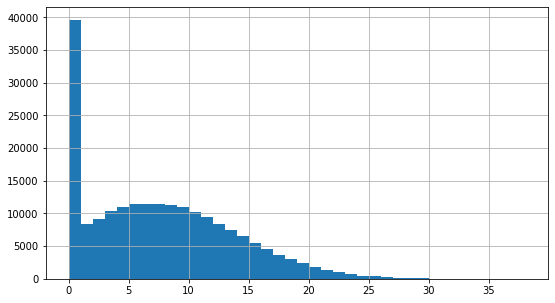

In [20]:
show_descr_hist(calls, 'duration', (0, 38), 38)

Бросается в глаза только то, что звонков с нулевой длительностью очень много, почти 20%.

In [21]:
print(f'Звонков с нулевой длительностью: {calls.loc[calls["duration"] == 0, "duration"].count() / calls.shape[0]:.2%}')

Звонков с нулевой длительностью: 19.55%


Звонки с нулевой длительностью - звонки, в которых один из абонентов начал звонок, но звонок по какой-то причине не состоялся (не дозвонился, передумал звонить и т.д.)). Поэтому такие звонки доносят до нас только факт попытки связаться. А с точки зрения анализа расхода количества включенных в тариф минут такие звонки нам не интересны.  

Звонков с нулевой длительностью слишком много, чтобы все такие звонки удалять. Просто будем далее использовать срез с ненулевыми звонками.

In [22]:
not_zero_calls = calls[calls['duration'] > 0]

Поиск ошибок с столбце **call_date** таблицы calls

Убираем предупреждения pandas.

In [23]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

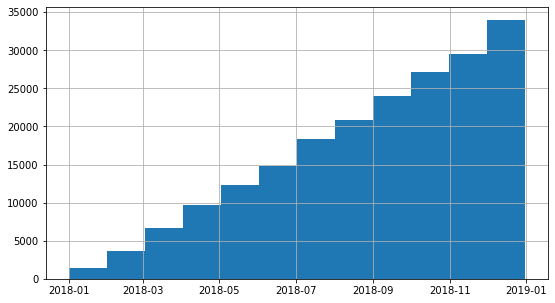

In [24]:
show_descr_hist(calls, 'call_date', None, 12)

Количество звонков увеличивается линейно, ничего подозрительного не обнаружено.  

Отметим временной интервал: 1 января 2018 года - 31 декабря 2018 года. То есть ровно 2018 год.

#### Поиск ошибок в столбце mb_used столбца internet

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

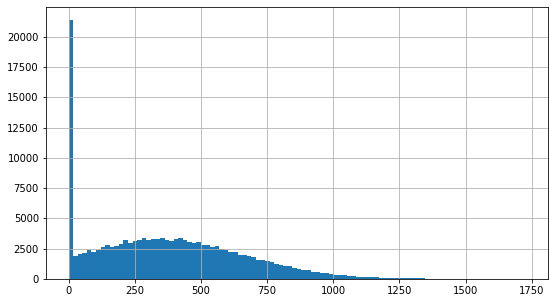

In [25]:
show_descr_hist(internet, 'mb_used', None, 100)

Как и в случае с длительностью звонков вызывает подозрение столбец с нулевыми затратами трафика во время интернет сессии. Однако звонки с нулевой длительностью поддаются объяснению.  
Если сессия зарегистрирована, то для её создания уже должны были быть отправлены хоть какие-нибудь данные.  

В исходном датасете эти данные представлены числами с плавающей точкой, дробная часть которых представлена двумя цифрами. **Возможно**, при выгрузке данных в датасет все значения меньше 0.01 были округлены до 0.00.  

Проверим количество нулевых значений.

In [26]:
print(f'Сессий с нулевой затратой трафика: {internet.loc[internet["mb_used"] == 0, "mb_used"].count() / internet.shape[0]:.2%}')

Сессий с нулевой затратой трафика: 13.12%


Сессий с нулевой затратой трафика слишком много, чтобы удалять такие строки. Поэтому оставим эти строки. При необходимости возьмем срез с ненулевыми данными.

In [27]:
not_zero_session = internet[internet['mb_used'] > 0]

#### Поиск ошибок в столбце session_date таблицы internet

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

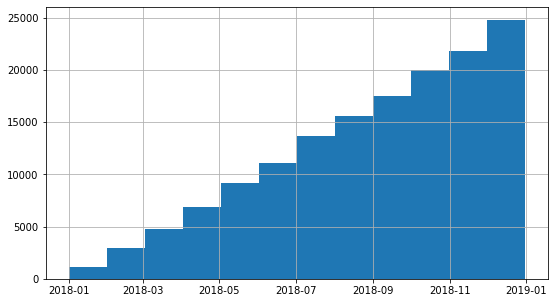

In [28]:
show_descr_hist(internet, 'session_date', None, 12)

Всё отлично, интервал совпадает с интервалом звонков.

#### Поиск ошибок в столбце message_date таблицы messages

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

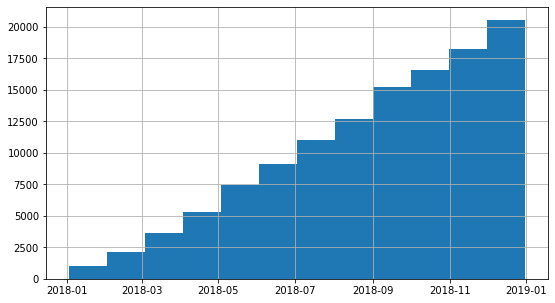

In [29]:
show_descr_hist(messages, 'message_date', None, 12)

Интервал тот же.

#### Поиск ошибок в столбце age таблицы users

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

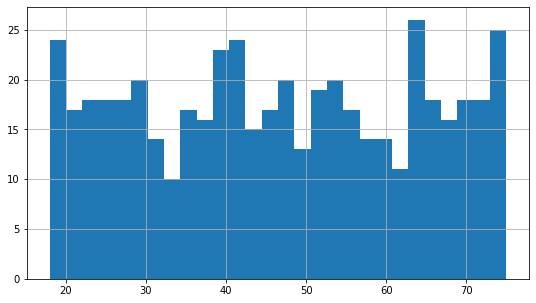

In [30]:
show_descr_hist(users, 'age', (18, 75), 28)

Ничего подозрительного не обнаружено. У нас не так много клиентов в выборке, поэтому гистограмма не самая равномерная.

#### Поиск ошибок в столбце city таблицы users

Посмотрим в каком формате встречаются названия населенных пунктов.

In [31]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Названия всех населенных пунктов находятся в одном формате, никакие действия не требуются.

#### Поиск ошибок в столбце reg_date таблицы users

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

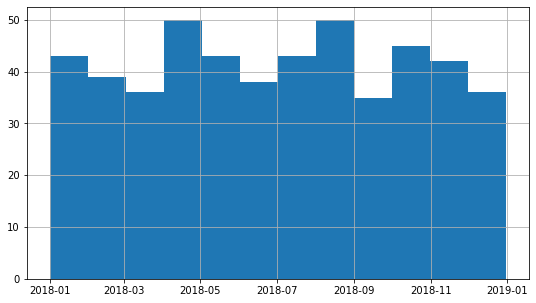

In [32]:
show_descr_hist(users, 'reg_date', None, 12)

Временной интервал тот же. Тот факт, что каждый месяц регистрируется похожее количество людей объясняет линейный прирост количества звонков и выходов в интернет. То есть каждый человек каждый месяц звонит и выходит в интернет +- одинаково, просто количество клиентов увеличивается.  

#### Поиск ошибок в столбце tariff таблицы users

Посмотрим на то, какими тарифами пользуются люди.

In [33]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Всё хорошо, логично, ничего лишнего.

#### Поиск и обработка ошибок. Вывод.

Обнаруженные ошибки:
1. Нецелые значения в столбцах duration (длительность сессии) и mb_used (объем потраченого трафика)
2. Звонки с нулевой длительностью
3. Сессии в интернете с нулевой затратой трафика
4. Странный столбец "Unnamed: 0"  

Как ошибки были обработаны:
1. Нецелые значения были округлены вверх  
2. Получен срез со звонками ненулевой длительности
3. Получен срез с сессиями с ненулевыми затратами трафика
4. Данный столбец был удалён  

**Предположительно**: 
- Звонки с нулевой длительностью - звонки, в которых один клиент начал звонок, но по какой-то причине не дозвонился.
- Сессии с нулевой затратой трафика появились в момент выгрузки данных в таблицу csv. Возможно в этот момент значения меньше 0.01 (10 килобайт) были округлены до 0.
- В таблице internet.csv присутствует безымянный столбец с id сессий.  

**Предложения**:
- Проверить предположение относительно округления до 0 значений затраченного трафика
- Проверить таблицу internet.csv

### Рассчет дополнительных параметров

Для каждого пользователя посчитаем:
- Количество сделанных звонков и израсходованных минут разговора по месяцам
- Количество отправленных сообщений по месяцам
- Объем израсходованного интернет-трафика по месяцам
- Помесячную выручку с каждого пользователя

Посчитаем количество звонков и израсходованных минут разговора по месяцам.  
Для этого в каждую из таблиц calls, messages и internet добавим отдельный столбец, который будет содержать номер месяца.

In [34]:
calls['call_month'] = calls['call_date'].dt.month

In [35]:
messages['message_month'] = messages['message_date'].dt.month

In [36]:
internet['session_month'] = internet['session_date'].dt.month

Таблица количества звонков по месяцам:

In [37]:
calls_count_per_month = calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc='count', dropna=False)

calls_count_per_month.reset_index(inplace=True)
calls_count_per_month.set_axis(['user_id','month','calls_count'], axis='columns', inplace=True)
calls_count_per_month

,user_id,month,calls_count
0,1000,1,NaN
1,1000,2,NaN
2,1000,3,NaN
3,1000,4,NaN
4,1000,5,22.0
...,...,...,...
5899,1499,8,NaN
5900,1499,9,9.0
5901,1499,10,68.0
5902,1499,11,74.0


Таблица суммарной длительности звонков по месяцам:

In [38]:
calls_duration_per_month = calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc='sum', dropna=False)

calls_duration_per_month.reset_index(inplace=True)
calls_duration_per_month.set_axis(['user_id','month','calls_duration'], axis='columns', inplace=True)
calls_duration_per_month

,user_id,month,calls_duration
0,1000,1,NaN
1,1000,2,NaN
2,1000,3,NaN
3,1000,4,NaN
4,1000,5,159.0
...,...,...,...
5899,1499,8,NaN
5900,1499,9,70.0
5901,1499,10,449.0
5902,1499,11,612.0


Таблица количества отправленных сообщей по месяцам:

In [39]:
messages_count_per_month = messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc='count', dropna=False)

messages_count_per_month.reset_index(inplace=True)
messages_count_per_month.set_axis(['user_id','month','messages_count'], axis='columns', inplace=True)
messages_count_per_month

,user_id,month,messages_count
0,1000,1,NaN
1,1000,2,NaN
2,1000,3,NaN
3,1000,4,NaN
4,1000,5,22.0
...,...,...,...
5107,1499,8,NaN
5108,1499,9,11.0
5109,1499,10,48.0
5110,1499,11,59.0


Таблица истраченного интернет-трафика по месяцам:

In [40]:
mb_used_per_month = internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum', dropna=False)

mb_used_per_month.reset_index(inplace=True)
mb_used_per_month.set_axis(['user_id','month','mb_used'], axis='columns', inplace=True)
mb_used_per_month

,user_id,month,mb_used
0,1000,1,NaN
1,1000,2,NaN
2,1000,3,NaN
3,1000,4,NaN
4,1000,5,2256.0
...,...,...,...
5959,1499,8,NaN
5960,1499,9,1848.0
5961,1499,10,17809.0
5962,1499,11,17984.0


Соберем общую таблицу, которая будет содержать следующие данные для каждого клиента за каждый месяц:
- id пользователя
- месяц
- длительность звонков
- количество отправленных сообщений
- объем использованного трафика
- тариф
- все данные по тарифу

In [41]:
users_month_stat = (
    calls_duration_per_month.merge(messages_count_per_month, on=['user_id', 'month'], how='outer')
    .merge(mb_used_per_month, on=['user_id', 'month'], how='outer')
    .merge(users[['user_id', 'tariff', 'city']], on='user_id', how='outer')
)
users_month_stat.set_axis(
    ['user_id','month','calls_duration', 'messages_count', 'mb_used', 'tariff_name', 'city'], 
    axis='columns', inplace=True
)
users_month_stat = users_month_stat.merge(tariffs, on='tariff_name', how='outer')
users_month_stat

,user_id,month,calls_duration,messages_count,mb_used,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,1.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,2.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,3.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,4.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,5.0,159.0,22.0,2256.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,1489,9.0,NaN,32.0,17232.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
5974,1489,10.0,NaN,21.0,19588.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
5975,1489,11.0,NaN,20.0,17516.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
5976,1489,12.0,NaN,35.0,17341.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3


Пропуски в таблице возникают в результате выполнения слияния с параметром how равным 'outer'. Это значит, что по какому-то клиенту в какой-то месяц отсутствует какая-то информация (этот клиент в этот месяц не звонил/не писал сообщения/не выходил в интернет)

Создадим функции для высчитывания оплаты услуг сверх включенного в тариф.

In [42]:
def calculate_calls_overpayment(row):
    if row['calls_duration'] > row['minutes_included']:
        return (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    else:
        return 0
    
def calculate_messages_overpayment(row):
    if row['messages_count'] > row['messages_included']:
        return (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    else:
        return 0
    
def calculate_internet_overpayment(row):
    if row['mb_used'] > row['mb_per_month_included']:
        return (math.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb'])
    else:
        return 0

Применим созданные функции.

In [43]:
users_month_stat['calls_overpayed'] = users_month_stat.apply(calculate_calls_overpayment, axis=1)
users_month_stat['messages_overpayed'] = users_month_stat.apply(calculate_messages_overpayment, axis=1)
users_month_stat['internet_overpayed'] = users_month_stat.apply(calculate_internet_overpayment, axis=1)

In [44]:
users_month_stat

,user_id,month,calls_duration,messages_count,mb_used,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overpayed,messages_overpayed,internet_overpayed
0,1000,1.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
1,1000,2.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
2,1000,3.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
3,1000,4.0,NaN,NaN,NaN,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
4,1000,5.0,159.0,22.0,2256.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,1489,9.0,NaN,32.0,17232.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,400
5974,1489,10.0,NaN,21.0,19588.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,1000
5975,1489,11.0,NaN,20.0,17516.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,600
5976,1489,12.0,NaN,35.0,17341.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,400


В таблицу добавим столбец, содержащий суммарные затраты каждого клиента за каждый месяц.

In [45]:
users_month_stat['month_total'] = (users_month_stat['calls_overpayed'] + 
                                   users_month_stat['messages_overpayed'] + 
                                   users_month_stat['internet_overpayed'] + 
                                   users_month_stat['rub_monthly_fee'])

Выведем топ-5 по затратам в месяц.

In [46]:
users_month_stat[['user_id', 'month', 'month_total']].sort_values(by='month_total', ascending=False).head(5)

,user_id,month,month_total
5856,1486,12.0,6770.0
2160,1042,12.0,5709.0
5855,1486,11.0,5680.0
4092,1261,12.0,5672.0
4296,1286,12.0,5321.0


Похоже на правду. Каких-то аномальных затрат в месяц ни у кого нет.

#### Вывод

Для каждого клиента были рассчитаны следующие параметры: 
- Количество сделанных звонков и израсходованных минут разговора по месяцам
- Количество отправленных сообщений по месяцам
- Объем израсходованного интернет-трафика по месяцам
- Помесячную выручку с каждого пользователя  

Полученные таблицы показали:
- Некоторые клиенты подключили себе тариф в один из месяцев рассматриваемого периода
- Некоторые клиенты в некоторые месяцы не пользовались сообщениями, интернетом или звонками

Все значения во всех таблицах выглядят достоверно.

### Анализ полученных данных

Необходимо описать поведение клиентов, опираясь на выборку. 
Посчитаем среднемесячные потребности клиентов каждого тарифа. 
Оценим такие характеристики положения данных как среднее, дисперсия и стандартное отклонение.
Для упрощения восприятия воспользуемся визуализацией.

Начнем с рассчета среднемесячных потребностей клиентов каждого тарифа. Для этого отдельно для каждого тарифа и для каждой услуги найдем средние затраты каждого клиента. Учитывать будем только те месяцы, в которые клиент этими услугами пользовался.  

Рассчитаем среднюю длительность звонков для клиентов каждого тарифа.

In [47]:
service_mean_dict = {
    'calls_duration': {},
    'messages_count': {},
    'mb_used': {}
}

for tariff in tariffs['tariff_name'].unique():
    for service in ['calls_duration', 'messages_count', 'mb_used']:
        service_mean = (users_month_stat.loc[users_month_stat['tariff_name'] == tariff]
                        .dropna().pivot_table(index='user_id', columns='month', values=service, aggfunc='mean')
                        .mean(axis=1).mean())
        service_mean_dict[service][tariff] = service_mean

Построим столбчатые диаграммы.

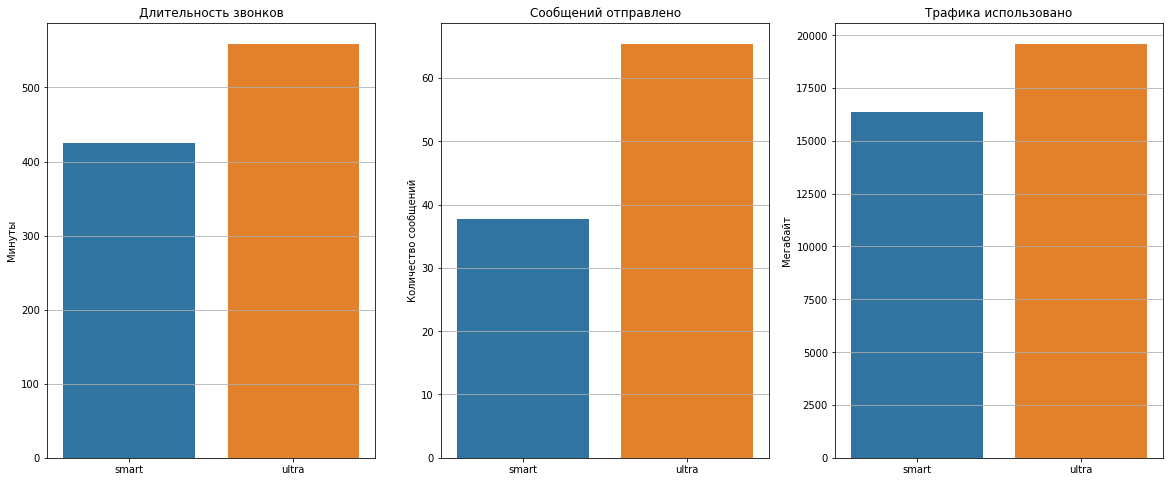

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for (service, ax, ylabel, title) in zip(service_mean_dict.values(), 
                         axes, 
                         ['Минуты', 'Количество сообщений', 'Мегабайт'], 
                         ['Длительность звонков', 'Сообщений отправлено', 'Трафика использовано']):
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid()
    sns.barplot(x=list(service.keys()), y=list(service.values()), ax=ax)
    
services_mean_barplot = fig  #Сохранение диграммы в переменную

Посчитаем дисперсию для каждой услуги для клиентов каждого тарифа.

In [49]:
service_var_dict = {
    'calls_duration': {},
    'messages_count': {},
    'mb_used': {}
}

for tariff in tariffs['tariff_name'].unique():
    for service in ['calls_duration', 'messages_count', 'mb_used']:
        service_var = np.var(
            users_month_stat.loc[users_month_stat['tariff_name'] == tariff]
            .pivot_table(index='user_id', columns='month', values=service, aggfunc='mean')
            .mean(axis=1), ddof=1)
        service_var_dict[service][tariff] = service_var

Посчитаем стандартное отклонение для каждой услуги для клиентов каждого тарифа.

In [50]:
service_std_dict = {
    'calls_duration': {},
    'messages_count': {},
    'mb_used': {}
}

for service_key, service_value in service_var_dict.items():
    for tariff_key, tariff_value in service_value.items():
        service_std_dict[service_key][tariff_key] = math.sqrt(tariff_value)

Составим таблицу, отображающую среднее значение, дисперсию и стандартное отклонение для каждой услуги для клиентов каждого тарифа.

In [51]:
std_table = pd.DataFrame.from_dict(service_std_dict)

In [52]:
mean_table = pd.DataFrame.from_dict(service_mean_dict)

In [53]:
var_table = pd.DataFrame.from_dict(service_var_dict)

In [54]:
pd.concat([mean_table, var_table, std_table], keys=['Среднее значение', 'Дисперсия', 'Стандартное отклонение']).style.format("{:.2f}")

Клиенты более дорогого тарифа "ultra" каждый месяц пользуются б*о*льшим количеством услуг, чем клиенты тарифа "smart".  
Заметно, что клиенты тарифа "ultra" используют услуги менее равномерно. То есть в один месяц клиент с тарифом "ultra" может потратить 10Гб трафика, а в другой 30.

In [55]:
### Код ревьювера ###
# альтернативный вариант:

users_month_stat.groupby('tariff_name').agg({'calls_duration':['mean', np.std, np.var],
                                             'messages_count': ['mean', np.std, np.var],
                                             'mb_used': ['mean', np.std, np.var]}).T.astype('int')

tariff_name             smart     ultra
calls_duration mean       419       545
               std        189       306
               var      35844     94203
messages_count mean        38        61
               std         26        45
               var        717      2109
mb_used        mean     16236     19686
               std       5868      9952
               var   34443100  99043439

Построим гистограммы по среднемесячному использованию услуг клиентами разных тарифов.

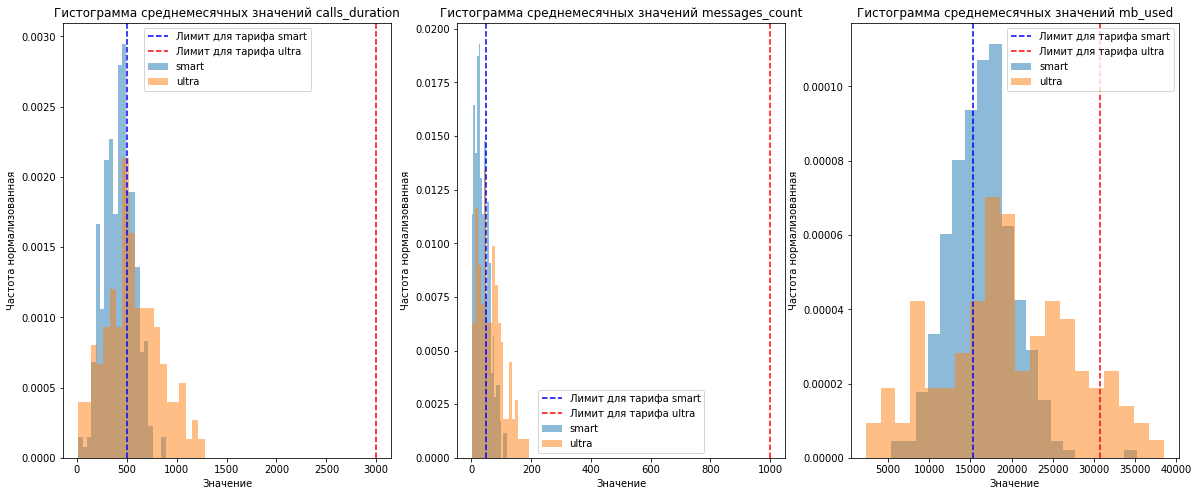

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, service in enumerate(zip(['calls_duration', 'messages_count', 'mb_used'], 
                                ['minutes_included', 'messages_included', 'mb_per_month_included'])):
    service, included = service
    for tariff, color in zip(tariffs['tariff_name'].unique(), ['b', 'r']):
        service_mean = (users_month_stat.loc[users_month_stat['tariff_name'] == tariff]
                        .dropna().pivot_table(index='user_id', columns='month', values=service, aggfunc='mean')
                        .mean(axis=1))
        axes[i].hist(service_mean, alpha=0.5, bins=20, density=True, label=tariff)
        axes[i].axvline(x=tariffs.loc[tariffs['tariff_name'] == tariff, 
                        included].values[0], 
                        c=color, 
                        linestyle='--', 
                        label=f'Лимит для тарифа {tariff}')
        axes[i].set_title(f'Гистограмма среднемесячных значений {service}')
        axes[i].set_xlabel('Значение')
        axes[i].set_ylabel('Частота нормализованная')
        axes[i].legend()
        axes[i].grid()

#### Вывод

Клиенты тарифа "ultra" пользуются б*о*льшим количеством услуг ежемесячно, чем клиенты тарифа "smart". Это логично, так как тариф "ultra" дороже и предоставляет клиентам большее количество включенных услуг.  

Среднемесячные длительность звонков и объем использованого трафика распределены нормально для обоих тарифов. При чем распределение для тарифа "ultra" более равномерное.  

Диаграмма среднемесячного количества отправленных сообщений скошена вправо для обоих тарифов. Распределение для тарифа "ultra" также более равномерное.  

Представленные выше диаграммы соответствуют таблице характеристик положения данных. 

### Проверка гипотез

Проверим две гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов  

Начнем с проверки первой гипотезы.  

Сформируем нулевую гипотезу **H0**. 
**H0** - средняя выручка пользователей тарифов "Ультра" и "Смарт" одинакова.  

Сформируем альтернативную гипотезу **H1**.
**H1** - средняя выручка пользователей тарифов "Ультра" и "Смарт" различается.

Для проверки равенства средних наборов данных (в нашем случае клиентов с разными тарифами) одной генеральной совокупности используется метод scipy.stats.ttest_ind().  

Необходимо посчитать средние выручки оператора с клиентов разных тарифов и задать критический уровень статистической значимости. 
Поскольку нам не важно в какую сторону средние могут различаться, то будем проверять двухстороннюю гипотезу.  

Найдем средние значения для клиентов каждого тарифа.

In [57]:
ultra_month = users_month_stat.loc[users_month_stat['tariff_name'] == 'ultra', 'month_total']
ultra_month_mean = ultra_month.mean()

smart_month = users_month_stat.loc[users_month_stat['tariff_name'] == 'smart', 'month_total']
smart_month_mean = smart_month.mean()

In [58]:
print(f'Средняя выручка оператора с клиентов тарифа "ultra": {ultra_month_mean:.2f}')
print(f'Средняя выручка оператора с клиентов тарифа "smart": {smart_month_mean:.2f}')

Средняя выручка оператора с клиентов тарифа "ultra": 2017.11
Средняя выручка оператора с клиентов тарифа "smart": 945.10


Зададим критический уровень статистической значимости. Возьмем "стандартное" значение 0.05. 

In [59]:
alpha = 0.05

Посчитаем дисперсии для обеих выборок.

In [60]:
for i, variance in enumerate([ultra_month, smart_month], 1):
    print(f'Дисперсия {i}-ой выборки: {np.var(variance, ddof=1)}')

Дисперсия 1-ой выборки: 83124.96197660801
Дисперсия 2-ой выборки: 495640.5320863513


Дисперсии сильно различаются, поэтому параметр **equal_var** метода **ttest_ind** установим в False.  

Проверим гипотезу.

In [61]:
results = st.ttest_ind(ultra_month, smart_month, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


p-значение равно нулю, на основании чего можно отвергнуть нулевую гипотезу в пользу альтернативной. Поэтому можно считать, что выручка оператора с клиентов разных тарифов различается. Зная средние значения, можно с уверенностью сказать, что выручка с клиентов более дорогого тарифа "ultra" больше.  

Обратим внимание на то, что средняя выручка с клиентов тарифа "ultra" почти не отличается от ежемесячной платы за тариф. То есть этим клиентам чаще всего хватает включенного количества услуг.  
А клиенты тарифа "ultra" часто расходуют все включенные услуги, из-за чего им приходится докупать дополнительные пакеты услуг. В среднем они доплачивают 400р в месяц, что достаточно много, учитывая ежемесячную плату в 550р.

Проверим **вторую** гипотезу.

Сформируем нулевую гипотезу **H0**. **H0** - средняя выручка пользователей из Москвы и других регионов одинакова.

Сформируем альтернативную гипотезу **H1**. **H1** - средняя выручка пользователей из Москвы и других регионов различается.  

Воспользуемся тем же методом scipy.stats.ttest_ind(). Гипотеза также будет двухсторонняя.  

Посчитаем средние значения для клиентов из Москвы и из других регионов.

In [62]:
moscow_month = users_month_stat.loc[users_month_stat['city'] == 'Москва', 'month_total']
moscow_month_mean = moscow_month.mean()

not_moscow_month = users_month_stat.loc[users_month_stat['city'] != 'Москва', 'month_total']
not_moscow_month_mean = not_moscow_month.mean()

In [63]:
print(f'Средняя выручка оператора с клиентов из Москвы: {moscow_month_mean:.2f}')
print(f'Средняя выручка оператора с клиентов из других регионов: {not_moscow_month_mean:.2f}')

Средняя выручка оператора с клиентов из Москвы: 1252.10
Средняя выручка оператора с клиентов из других регионов: 1266.65


Клиенты из Москвы в среднем тратят столько же денег, сколько в среднем и клиенты из других регионов.  

Зададим критический уровень статистической значимости. Возьмем "стандартное" значение 0.05. 

In [64]:
alpha = 0.05

Посчитаем дисперсии для обеих выборок.

In [65]:
for i, variance in enumerate([moscow_month, not_moscow_month], 1):
    print(f'Дисперсия {i}-ой выборки: {np.var(variance, ddof=1)}')

Дисперсия 1-ой выборки: 575722.0022522332
Дисперсия 2-ой выборки: 622434.2902628282


Дисперсии различаются более, чем на 5 процентов, поэтому параметр **equal_var** метода **ttest_ind** установим в False. 

Проверим гипотезу.

In [66]:
results = st.ttest_ind(moscow_month, not_moscow_month, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5572310594935443
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не отвергаем. Скорее всего клиенты из Москвы и из других регионов тратят одинаковое количество денег на услуги оператора "Мегалайн."

#### Вывод

Были представлены следующие гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов  

При проверке каждой из этих гипотез были сформулированы нулевые и альтернативные гипотезы. Обе альтернативные гипотезы были двухсторонние, так как каждый раз мы проверяли равенство/неравенство средних значений выборок. 
При проверке каждой из гипотез критический уровень статистической значимости принимал значение 0.05. Данное значение стандартно. Оснований для изменения данного параметра в виде критичности ошибок первого или второго рода не было.  
Оба раз был использован метод scipy.stats.ttest_ind(), так как он применяется для проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.  

Результаты проверки гипотез:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различается. Пользователь тарифа "Ультра" приносит оператору больше денег, чем пользователь тарифа "Смарт".
2. Клиенты из Москвы в среднем тратят столько же денег на услуги оператора, сколько и клиенты из других регионов.

### Так какой же тариф лучше?

Одна из задач исследования - ответить на вопрос "какой тариф лучше?".  
На этот вопрос нельзя дать прямой ответ, так как выбор тарифа зависит от потребностей клиента. Поэтому вместо ответа на вопрос найдем границу, после которой имеет смысл взять более дорогой тариф "Ультра".  

Ежемесячный платеж за тариф "Смарт" - 550р. За тариф "Ультра" - 1950р. Разница составила 1400р. Поэтому оформлять тариф "Ультра" имеет смысл, если сумма доплат за дополнительные пакеты выше 1400р.

Найдем id пользователей, которым имеет смысл перейти тариф "Ультра".

In [67]:
smart_to_ultra = users_month_stat[(users_month_stat['tariff_name'] == 'smart')].pivot_table(index='user_id', values='month_total')
list(smart_to_ultra[smart_to_ultra['month_total'] >= 1950].index)

[1072, 1172, 1227, 1251, 1324, 1496]

Пользователям с указанными выше id имеет смысл перейти на тариф "Ультра", так как они тратят слишком много денег на дополнительные пакеты.  

Найдем пользователей, которым стоит перейти с тарифа "Смарт" на тариф "Ультра". Для этого посмотрим сколько бы тратили денег пользователи тарифа "Ультра", если бы они пользовались тарифом "Смарт".

In [68]:
tmp_stat = (
    calls_duration_per_month.merge(messages_count_per_month, on=['user_id', 'month'], how='outer')
    .merge(mb_used_per_month, on=['user_id', 'month'], how='outer')
    .merge(users[['user_id', 'tariff', 'city']], on='user_id', how='outer')
)

tmp_stat.set_axis(['user_id','month','calls_duration', 'messages_count', 'mb_used', 'tariff_name', 'city'], axis='columns', inplace=True)
tmp_stat = tmp_stat[tmp_stat['tariff_name'] == 'ultra']
tmp_stat['tariff_name'] = 'smart'
tmp_stat = tmp_stat.merge(tariffs, on='tariff_name', how='outer')

tmp_stat['calls_overpayed'] = tmp_stat.apply(calculate_calls_overpayment, axis=1)
tmp_stat['messages_overpayed'] = tmp_stat.apply(calculate_messages_overpayment, axis=1)
tmp_stat['internet_overpayed'] = tmp_stat.apply(calculate_internet_overpayment, axis=1)
tmp_stat['month_total'] = (tmp_stat['calls_overpayed'] + 
                           tmp_stat['messages_overpayed'] + 
                           tmp_stat['internet_overpayed'] + 
                           tmp_stat['rub_monthly_fee'])

ultra_to_smart = tmp_stat[(tmp_stat['tariff_name'] == 'smart')].pivot_table(index='user_id', values='month_total')
ultra_to_smart = list(ultra_to_smart[ultra_to_smart['month_total'] <= 1950].index)

print(len(ultra_to_smart))

110


110-ти клиентам тарифа "Ультра" стоит перейти на тариф "Смарт", так как они платят больше, чем используют.

#### Вывод

Однозначно определить какой тариф лучше сам по себе - невозможно. Однако тариф "Смарт" предлагает в основном ровно столько, сколько нужно клиенту. А клиенты тарифа "Ультра" часто платят слишком много и не расходуют все включенные услуги.  
При для оператора тариф "Ультра" как раз таки более предпочтительный.  

Наверняка среди клиентов тарифа "Ультра" много тех, кто хочет просто раз в месяц платить фиксированную сумму и не "париться". Пускай даже с небольшой переплатой.  
А тариф "Смарт" подходит тему, кто хочет платить ровно столько, сколько он использует.

### Общий вывод

Как ошибки были обработаны:
- Нецелые значения были округлены вверх
- Получен срез со звонками ненулевой длительности
- Получен срез с сессиями с ненулевыми затратами трафика
- Столбец Unnamed: 0 был удалён.

Предложения:
- Проверить предположение относительно округления до 0 значений затраченного трафика
- Проверить таблицу internet.csv

Для каждого пользователя были посчитаны дополнительные параметры:
- Количество сделанных звонков и израсходованных минут разговора по месяцам
- Количество отправленных сообщений по месяцам
- Объем израсходованного интернет-трафика по месяцам
- Помесячную выручку с каждого пользователя

Анализ параметров calls_duration, messages_count и mb_used показал:
- Клиенты тарифа "ultra" пользуются большим количеством услуг ежемесячно, чем клиенты тарифа "smart"
- Среднемесячные длительность звонков и объем использованого трафика распределены нормально для обоих тарифов
- Диаграмма среднемесячного количества отправленных сообщений скошена вправо для обоих тарифов  

Необходимо было проверить 2 гипотезы:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Результаты проверки гипотез:
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно различается.
- Клиенты из Москвы в среднем тратят столько же денег на услуги оператора, сколько и клиенты из других регионов.

Тариф "Ультра" подходит больше тем, кто использует б*о*льшее количество услуг. Также он подходит тем, кто готов заплатить больше, а потом не беспокоиться о дополнительных списаниях для покупки дополнительных пакетов услуг.  
Тариф "Смарт" выгоден для тех, кто использует меньше услуг и не хочет переплачивать.  

Оператор "Мегалайн" однозначно заинтересован в увеличении количества клиентов тарифа "Ультра".

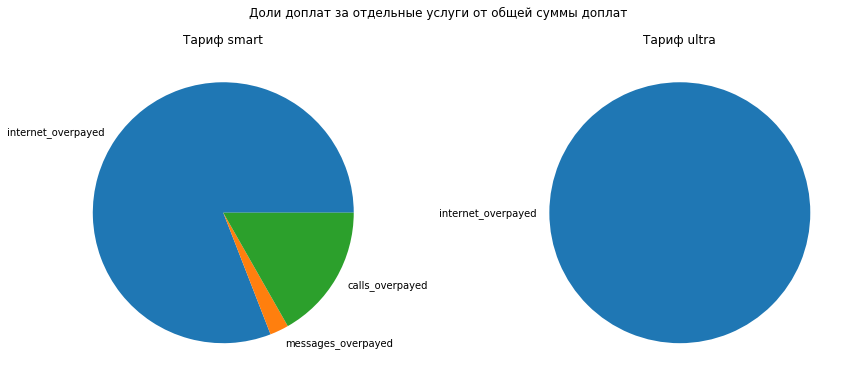

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), )

for i, tariff in enumerate(['smart', 'ultra']):
    pie_chart_data = users_month_stat.loc[
        users_month_stat['tariff_name'] == tariff, 
        ['internet_overpayed', 'messages_overpayed', 'calls_overpayed']
    ].mean()
    pie_chart_data = pie_chart_data[pie_chart_data != 0]
    
    labels = list(pie_chart_data.index)
    
    axes[i].pie(pie_chart_data, labels=labels)
    axes[i].set_title(f'Тариф {tariff}')
    fig.suptitle('Доли доплат за отдельные услуги от общей суммы доплат')


Как видно по диграммам выше, клиенты обоих тарифов в основном докупают интернет-трафик. Тариф "Ультра" стоит почти в 4 раза больше, чем тариф "Смарт", но предлагает всего в 2 раза больше интернета.  

На диаграмме ниже видно, что в среднем клиенты тарифа "Ультра" используют около 19Гб из 30 включенных.

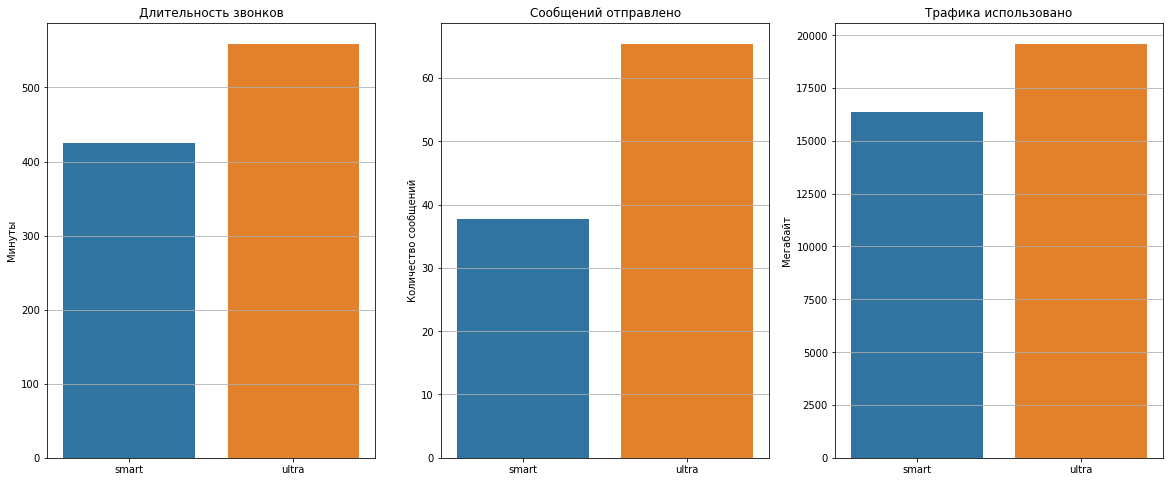

In [70]:
services_mean_barplot

Эти диаграммы подтверждают выводы, сделанные выше. Тариф "Смарт" для более рациональных пользователей. Тариф "Ультра" для тех, кто хочет платить единожды и не доплачивать.